<a href="https://colab.research.google.com/github/sigopt/sigopt-examples/blob/master/xgboost-py-regression/xgboost_py_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

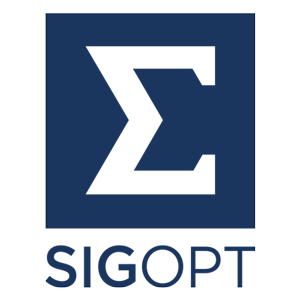

In this blog post I'm going to contrast our previous classifier example with another gradient-boosted tree model, a regression. First off, what's the difference between classification and regression?

A *classifier* looks at a row of data, and based on training data, identifies a class for it. This could as easily be fraud or "not fraud", "spam" or "ham," or even one of many dog breeds, depending on your dataset.

Meanwhile, a *regressor* attempts to predict a value or a score based on a number of factors or features, based on weights it learned from the training dataset.

Read on, as we'll attempt to predict California housing prices based on a standard dataset, with a similarly parametrized model to the one we use in the previous classficiation blog post. I'll explain how to track runs and experiments, as well as report multiple metrics. While you can optimize against either one or two metrics, today we'll just optimize against one and store the other for later use.

If you don't have XGBoost already installed in your Python or Anaconda environment, be sure to uncomment the first line. Then, let's start out by importing some useful libraries:

In [14]:
#!conda install -y -c conda-forge xgboost
#%config InlineBackend.figure_formats = ['retina'] # optional, in case you'd like to add high DPI charts

import pandas as pd
import numpy as np
import seaborn as sns
import time

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")  # don't spam the notebook with warnings

## Starting with data:
To keep things simple, we’ll use a standard, cleaned dataset that exists as part of scikit-learn to train our model: this time we'll use the California housing dataset. It consists of 30 numerical properties (or “features”) that predict whether a certain observation in a scan represents cancer or not, either “malignant” or “benign.” This output representation is the “target” or “label” for each row, representing an individual patient’s outcome.

If you uncomment it, the first line should install a recent version of the XGBoost package from conda-forge, in case you don’t have it in your environment already:

In [10]:
ch_dataset = fetch_california_housing()
data, target = fetch_california_housing(return_X_y=True)
X = pd.DataFrame(ch_dataset.data)
X.columns = ch_dataset.feature_names
y = target

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1337)

print(X.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


By printing the dataset column names, we can see that the features for our regression include standard properties of a house, including number of rooms by type, income, location, and more. Conveniently, all of these values have been translated to numerical values, so we don't have to do any transformation.

## Setting a baseline:

Let's train our regression with a somewhat rational set of parameters to start. This will serve as our baseline, after which, with SigOpt and Bayesian Optimization, we'll attempt to train a more accurate predictor of house price.

The following code defines an XGBoost regression model and fits the model against the training data we just imported.

In [15]:
gbm = xgb.XGBRegressor( 
                        n_estimators=30000,
                        max_depth=4,
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=50,
                    verbose=False
                   )

gbm.score(X_test, y_test)

[06:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8393731635633876

At around 0.85, this "score," or a R^2 value, indicates fairly high accuracy, although it also obfuscates the average error. While it is one metric for how a model performs, we'll also look at RMSE or root-mean squared error, which is actually the metric we'll ask SigOpt to minimize.

Speaking of optimization, let's set up SigOpt to optimize this regressor. In order to retrieve your API key, you'll need to [sign up here](https://app.sigopt.com/signup). It's free, so please go ahead and do that now. Once you have your key, paste it in the cell/block below:

In [16]:
# Install SigOpt's client library
!pip install sigopt
import sigopt
 
# Create a connection to SigOpt using either your Development or API token
from sigopt import Connection
 
# put your token here
api_token = "YOUR_API_TOKEN_HERE"
 
conn = Connection(client_token=api_token)

Next, in order to kick off the experimentation loop, you'll need to set up one Python functions that creates the model with all of the parameters you want to tune, and another that evaluates that model. Note that these are fairly similar in terms of parameters and search space as we used in our prior classification example, but that this model returns two metrics, RMSE and an accuracy score, which the scikit-learn documentation defines to be R^2:

In [18]:
def create_model(assignments):
    model = xgb.XGBRegressor(
                                n_estimators     = assignments['n_estimators'],
                                min_child_weight = assignments['min_child_weight'],
                                max_depth        = assignments['max_depth'],
                                gamma            = assignments['gamma'],
                                subsample        = assignments['subsample'],
                                colsample_bytree = assignments['colsample_bytree'],
                                reg_lambda       = assignments['lambda'],
                                reg_alpha        = assignments['alpha'],
                                learning_rate    = assignments['log_learning_rate'],
                                n_jobs           = 4
                            )
    return model

def evaluate_model(assignments):
    model = create_model(assignments)
    probabilities = model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(preds, y_test))
    
    return [
        dict(name="Accuracy Score", value=model.score(X_test, y_test)),
        dict(name="RMSE", value=rmse)
        ]

Note that rather than returning a singular metric, we return a dictionary comprising of two metrics. In the next block we'll specify which to optimize and which to merely track. Hanging onto metrics can be useful if you want to revisit a different aspect of your modeling problem later on in the development process.

Let's next create our experiment and set up all of the parameters and metrics to be tracked in the SigOpt dashboard:

In [19]:
experiment = conn.experiments().create(
    
    name="CA House Pricing XGB - Vanilla SigOpt",
 
    parameters=[
        dict(name="n_estimators", bounds=dict(min=50,max=350), type="int"),
        dict(name="min_child_weight", bounds=dict(min=2,max=15), type="int"),
        dict(name="max_depth", bounds=dict(min=3,max=10), type="int"),
        dict(name="gamma", bounds=dict(min=0,max=5), type="double"),
        dict(name="subsample", bounds=dict(min=0.5,max=1), type="double"),
        dict(name="colsample_bytree", bounds=dict(min=0.5,max=1), type="double"),
        dict(name="lambda", bounds=dict(min=0.00001, max=1), type="double", transformation="log"),
        dict(name="alpha", bounds=dict(min=0.00001, max=1), type="double", transformation="log"),
        dict(name="log_learning_rate", bounds=dict(min=0.00001 ,max=1), type="double", transformation="log")
        ],
 
    metrics=[
        dict(name="Accuracy Score", objective="maximize", strategy="store"),
        dict(name="RMSE", objective="minimize", strategy="optimize")
        ],
 
    observation_budget = 120,
)
 
print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

Explore your experiment: https://app.sigopt.com/experiment/389624/analysis


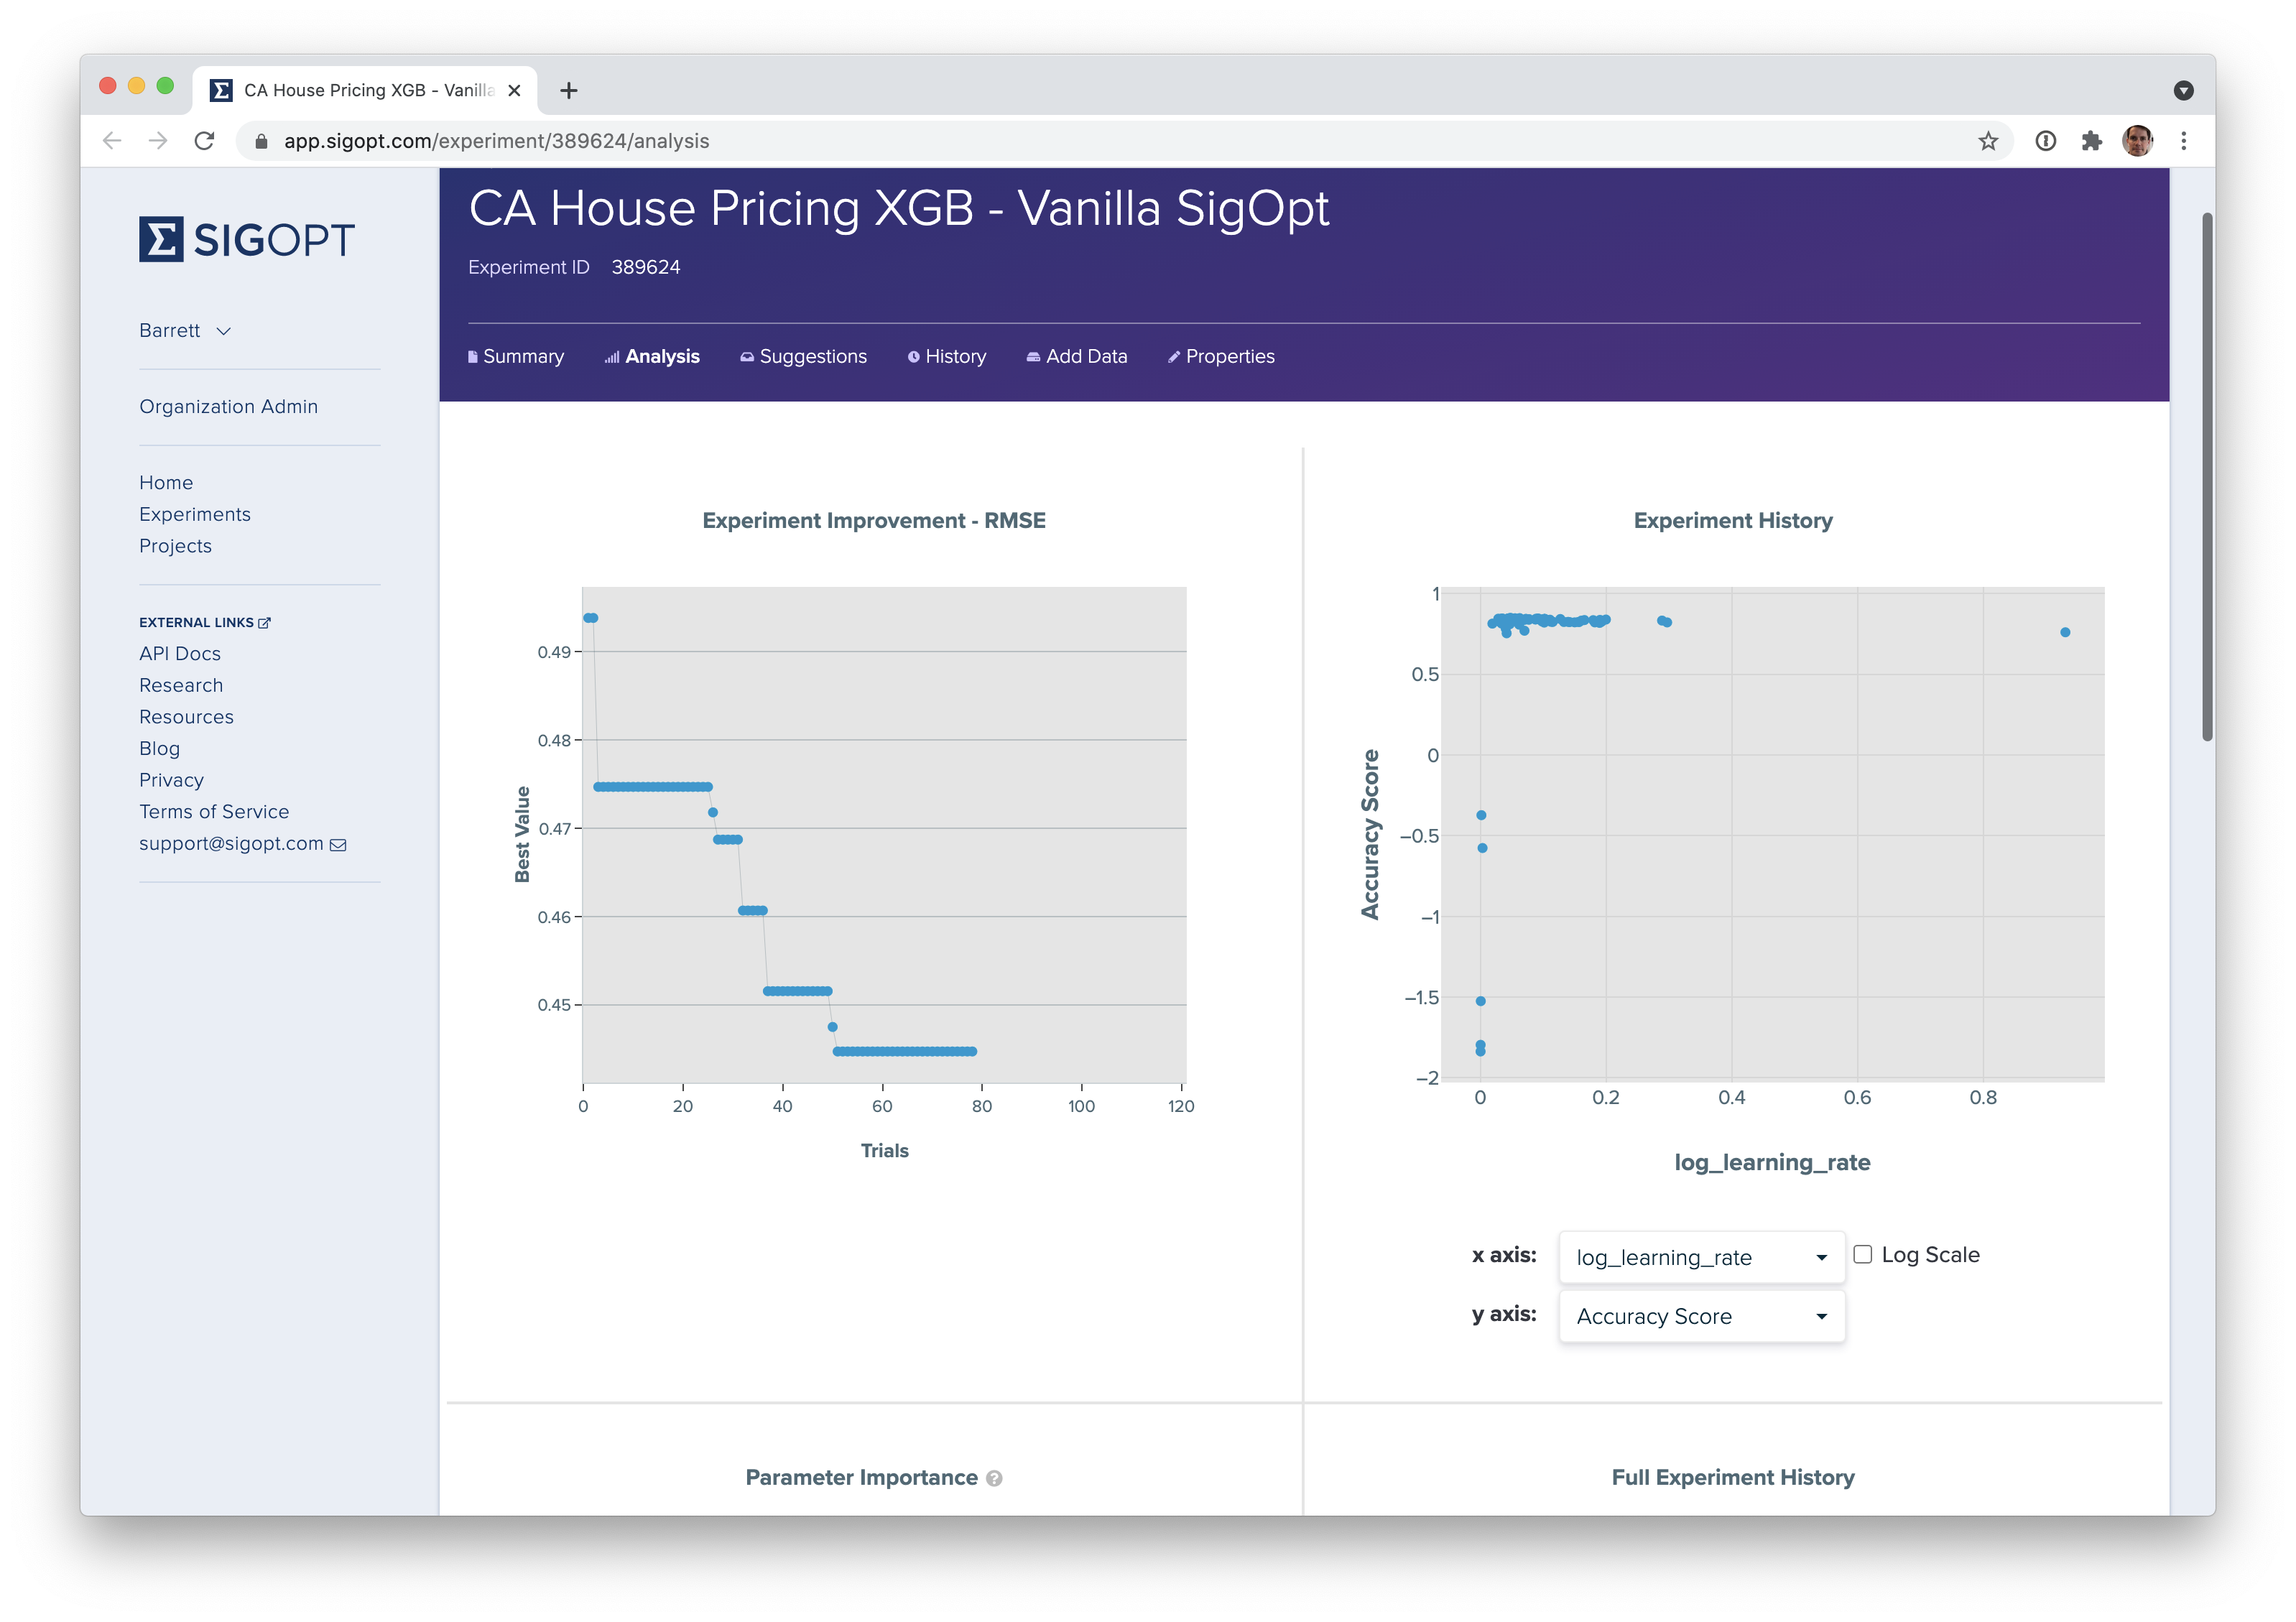

On the above page, you can start to see metrics come in for both RMSE and R^2 Score as SigOpt suggest better and better paramter sets, resulting in a higher performing model. Feel free to explore parameter importance and parallel coordinates.

*Note:*

On a 4-core system, the following set of 120 observations will take roughly 10 minutes to execute.

In [20]:
#Optimization Loop
for _ in range(experiment.observation_budget):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    assignments = suggestion.assignments
    value_dicts = evaluate_model(assignments)
 
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        values=value_dicts
    )
    
    #update experiment object
    experiment = conn.experiments(experiment.id).fetch()
 
assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments  
 
print("BEST ASSIGNMENTS FOUND: \n", assignments)

[06:27:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

At the bottom of your notebook or interpreter’s output, you should see the best set of parameters SigOpt was able to find in 120 automated training runs.

## Background on XGBoost’s parameters:
* `min_child_weight`, used to control over-fitting, this parameter is the sample size under which the model can not split a node. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
* `max_depth`, this is the maximum depth of a tree. This parameter controls over-fitting as higher depth will allow the model to learn relations very specific to a particular sample.
* `gamma`, this parameter specifies the minimum loss reduction required to make a split. The larger gamma is, the more conservative the algorithm will be. subsample, defines the ratio of the training instances. For example setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees, preventing overfitting
* `colsample_bytree`, defines the fraction of features to be randomly sampled for each tree. alpha and lambda are the L1 and L2 regularization terms on weights. Both values tend to prevent overfitting as they are increased. Additionally, Alpha can be used in case of very high dimensionality to help a model training converge faster
* `learning_rate` controls the weighting of new trees added to the model. Lowering this value will prevent overfitting, but require the model to add a larger number of tree

## Wrapping up:
Today we explored regression on an example dataset, but you can also apply these techniques to predict all kinds of numerical outcomes based on historical training data. You can easily discover for yourself how SigOpt facilitates a robust, efficient, and well-tracked experimentation process. Aside from ease-of-use, SigOpt delivers much better optimization performance, when compared with human-tuned parameters or an exhaustive approach like grid search. If you’d like, [you can find the original iPython Jupyter Notebook code for this example here](https://github.com/sigopt/sigopt-examples/blob/master/xgboost-py-regression/xgboost_py_regressor.ipynb), or you can [run it on Colab here](https://colab.research.google.com/github/sigopt/sigopt-examples/blob/master/xgboost-py-regression/xgboost_py_regressor.ipynb). 

If you'd like to head back to the previous post, covering [classification](https://sigopt.com/blog/xgboost-classification-optimization/) instead of regression, [you can find that here](https://sigopt.com/blog/xgboost-classification-optimization/).